In [2]:
import shapefile
from shapely.geometry import shape, Point, mapping
import numpy as np
import pandas as pd
import sys
sys.path.append("../..")
from src.data import utils

base = "../../data/"
filename = "raw/2016_LGA_SHAPE/LGA_2016_AUST"

sf = shapefile.Reader(base+filename)

centroids = list(map(lambda x: shape(x.__geo_interface__).centroid, sf.shapes()[:130]))

df = pd.DataFrame(sf.records())
nswdf = df[df[4] =="New South Wales"]
# drop "No usual address" - not a useful LGA
nswdf = nswdf[nswdf[0] != "LGA19499"]
nswdf.columns = ["code", "codenum", "name", "unknown", "state", "unknown2"]
nswdf["clean_name"] = nswdf["name"].str.extract('([^\\(]*)', expand=False).str.strip()
nswdf['long'] = np.asarray([x.x for x in centroids])
nswdf['lat'] = np.asarray([x.y for x in centroids])
nswdf

,code,codenum,name,unknown,state,unknown2,clean_name,long,lat
0,LGA10050,10050,Albury (C),1,New South Wales,305.9459,Albury,146.970424,-36.026604
1,LGA10130,10130,Armidale Regional (A),1,New South Wales,8620.6990,Armidale Regional,151.829150,-30.336349
2,LGA10250,10250,Ballina (A),1,New South Wales,484.9389,Ballina,153.486147,-28.852885
3,LGA10300,10300,Balranald (A),1,New South Wales,21690.6753,Balranald,143.611623,-33.950350
4,LGA10470,10470,Bathurst Regional (A),1,New South Wales,3817.8646,Bathurst Regional,149.525634,-33.430139
5,LGA10550,10550,Bega Valley (A),1,New South Wales,6278.8811,Bega Valley,149.717569,-36.825941
6,LGA10600,10600,Bellingen (A),1,New South Wales,1600.4337,Bellingen,152.728589,-30.403803
7,LGA10650,10650,Berrigan (A),1,New South Wales,2065.7759,Berrigan,145.711213,-35.734325
8,LGA10750,10750,Blacktown (C),1,New South Wales,240.0487,Blacktown,150.864351,-33.741329
9,LGA10800,10800,Bland (A),1,New South Wales,8557.6535,Bland,146.961268,-33.894344


In [3]:
#recast all lat long as distance & direction from mean centroid
#31.2532° S, 146.9211° E
mean_long = nswdf["long"].mean()
mean_lat = nswdf["lat"].mean()
mean_centroid = Point(mean_long, mean_lat)
distances = []
for centroid in centroids:
    distances.append((mean_long-centroid.x, mean_lat-centroid.y))
    
    
nswdf["long_dist"] = pd.Series([x[0] for x in distances])
nswdf["lat_dist"] = pd.Series([x[1] for x in distances])
mean_long, mean_lat

(149.59872792116178, -32.98412445113045)

In [5]:
nswdf_target = utils.load_target()
#target.columns23
nswdf_target=nswdf_target.set_index("LGA")
nswdf_target.loc[nswdf_target["Assault - domestic violence"] > 1800]

,Assault - domestic violence,Assault - non-domestic violence,Fraud,Sexual Offences,Malicious damage to property,Prohibited weapons offences
LGA,,,,,,
Moree Plains,1869.0213,1258.2781,662.2517,478.2929,3958.7932,603.3848
Walgett,1837.0231,1271.7852,361.1242,282.6189,3281.5199,596.6400


In [6]:
#average distance between nearest neighbours
dist = []
for i in centroids:
    alldist = []
    for j in centroids:
        if i != j:
            alldist.append(i.distance(j))
    dist.append(np.min(alldist))
    
np.mean(dist)

0.46813379855385656

In [7]:
%matplotlib inline
#stratify based on east/west distance from centroid
#get classes for stratification
class_boundaries = [-10] + [nswdf["long_dist"].quantile(x) for x in (np.asarray(range(20, 100, 20)) / 100)]

class_boundaries
for i, lower in enumerate(class_boundaries):
    lower_ix = nswdf["long_dist"] >= lower
    if i < len(class_boundaries) - 1:
        final_ix = (nswdf["long_dist"] < class_boundaries[i+1]) & lower_ix
    else:
        final_ix = lower_ix
        
    nswdf.loc[final_ix,"strat_class"] = i
nswdf["strat_class"]


0      4.0
1      0.0
2      0.0
3      4.0
4      3.0
5      2.0
6      0.0
7      4.0
8      2.0
9      4.0
10     3.0
11     2.0
12     4.0
13     1.0
14     4.0
15     4.0
16     4.0
17     1.0
18     0.0
19     3.0
20     2.0
21     2.0
22     1.0
23     1.0
24     4.0
25     0.0
26     4.0
27     1.0
28     0.0
29     4.0
      ... 
100    1.0
101    3.0
102    3.0
103    1.0
104    1.0
105    1.0
106    2.0
107    3.0
108    0.0
109    1.0
110    0.0
111    2.0
112    3.0
113    0.0
114    4.0
115    0.0
116    3.0
117    3.0
118    3.0
119    0.0
120    3.0
121    4.0
122    3.0
123    1.0
124    2.0
125    2.0
126    2.0
127    0.0
128    3.0
129    4.0
Name: strat_class, Length: 130, dtype: float64

In [8]:
nswdf.loc[nswdf["clean_name"]=="Rockdale", "clean_name"] = "Bayside"
nswdf.loc[nswdf["clean_name"]=="Gundagai", "clean_name"] = "Cootamundra-Gundagai"
nswdf.loc[nswdf["clean_name"]=="Western Plains Regional", "clean_name"] = "Dubbo Regional"
nswdf.loc[nswdf["clean_name"]=="Greater Hume Shire", "clean_name"] = "Greater Hume"

In [10]:
master_df = nswdf_target.join(nswdf.set_index("clean_name"))
master_df[master_df["name"].isnull()]

,Assault - domestic violence,Assault - non-domestic violence,Fraud,Sexual Offences,Malicious damage to property,Prohibited weapons offences,code,codenum,name,unknown,state,unknown2,long,lat,long_dist,lat_dist,strat_class
LGA,,,,,,,,,,,,,,,,,


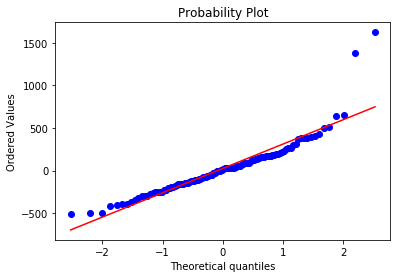

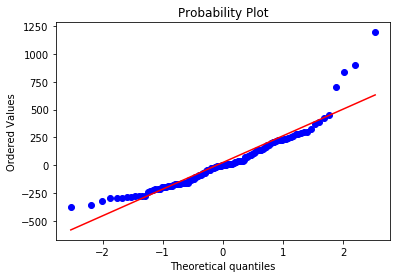

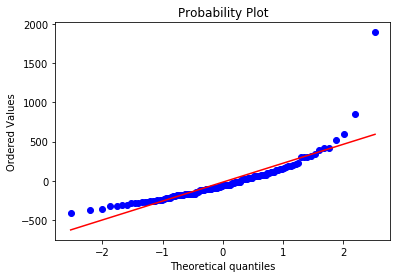

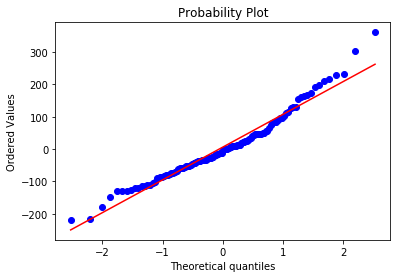

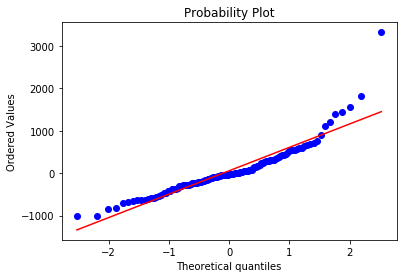

[55.22116883097276,
 45.718159386482945,
 36.03318427759154,
 44.74910126562506,
 44.872973430105105,
 64.5116085955761]

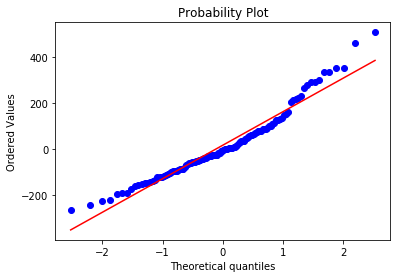

In [22]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from scipy.stats import probplot

from matplotlib import pyplot as plt

def kfold_cv(k, crimenum, dataframe):
    start_col = dataframe.columns.get_loc('Assault - domestic violence')
    skf = StratifiedKFold(k)
    
    mus = []
    sigmas = []
    rmse = []
    mape = []
    
    output = pd.DataFrame(index=range(len(dataframe)))
    models = []
    dataframe = dataframe.copy()
    dataframe["preds"] = pd.Series()
    for train_index, test_index in skf.split(dataframe, dataframe["strat_class"]):
        
        traindf = dataframe.iloc[train_index]
     
        testdf = dataframe.iloc[test_index]
        
        model = GaussianProcessRegressor(kernel=1.0 * RBF(0.48, (0.01,1)) + 1.0 * WhiteKernel(), normalize_y=True, n_restarts_optimizer=10)

        model.fit(traindf[['lat_dist','long_dist']], traindf.iloc[:,start_col+crimenum])
        lga_loc = np.asarray(testdf[['lat_dist','long_dist']])
        #print(lga_loc)
        mu, sigma = model.predict(lga_loc, return_std=True)
        models.append(model)
        mus.append(mu)
        sigmas.append(sigma)
        mape.append(utils.mape(mu, testdf.iloc[:,start_col+crimenum]))
        rmse.append(np.sqrt(mean_squared_error(mu, testdf.iloc[:,start_col+crimenum])))
        dataframe.iloc[test_index, -1] = mu
        plt.show()
        
    preds = np.array([])
    for mu in mus:
        preds = np.append(preds, mu)
    probplot(dataframe.iloc[:, start_col+crimenum].values - np.asarray(preds),  dist='norm', plot=plt)
    
    mape.append(utils.mape(preds, dataframe.iloc[:, start_col+crimenum]))
    return mus, sigma, rmse, mape, dataframe, models

output = []
for i in range(6):
    output.append(kfold_cv(5, i, master_df))
[x[3][-1] for x in output]                                     

In [20]:
output[-1][-1][-4].kernel_

125**2 * RBF(length_scale=0.949) + 9.34**2 * WhiteKernel(noise_level=87.2)

In [28]:
preds_df = output[-1][-2]

for i in range(1,5):
    preds_df = preds_df.join(output[i][-2].iloc[:, -1], rsuffix=" "+output[i][-2].columns[i])
    
preds_df.to_csv(base+"clean/gp_spatial_predictions.csv")